In [1]:
!pip install accelerate -U
!pip install rouge

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
!git clone https://github.com/ryanzhumich/AESLC

Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 9.36 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [5]:
def sanitize_subject(subject):
    # Remove special characters from the subject
    return re.sub(r'[^a-zA-Z0-9\s]', '', subject)

In [6]:
import os
import re

def load_emails_and_subjects(emails_directory):
    emails = []
    subjects = []

    for filename in os.listdir(emails_directory):
        file_path = os.path.join(emails_directory, filename)

        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            email_text = file.read()

            # Extract subject from email body using regex
            match = re.search(r'@subject\s+(.*)', email_text, re.IGNORECASE | re.DOTALL)

            if match:
                subject = match.group(1).strip()
                email_body = re.sub(r'@subject\n(.+)\n', '', email_text).strip()
                preprocessed_email = preprocess_text(email_body)

                emails.append(preprocessed_email)
                subjects.append(subject)

    return emails, subjects

In [7]:
train_emails, tain_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/train')
dev_emails, dev_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/dev')
test_emails, test_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/test')

In [9]:
import pandas as pd

In [10]:
train_data = pd.DataFrame({'subject_line': tain_subjects, 'email_body': train_emails})
dev_data = pd.DataFrame({'subject_line': dev_subjects, 'email_body': dev_emails})
test_data = pd.DataFrame({'subject_line': test_subjects, 'email_body': test_emails})

In [11]:
train_data.head()

,subject_line,email_body
0,Bank of Montreal,note let know per conversation tanya review br...
1,Override letter for ABB,peter ca recall sent override letter essential...
2,Customer trip for Gary Hanks,esther gary asked send info business trip invi...
3,Caithness +,thursday october 25 2001 pm central time u can...
4,TECO EnergySource Inc.,tana eta amendment letter ready teco see could...


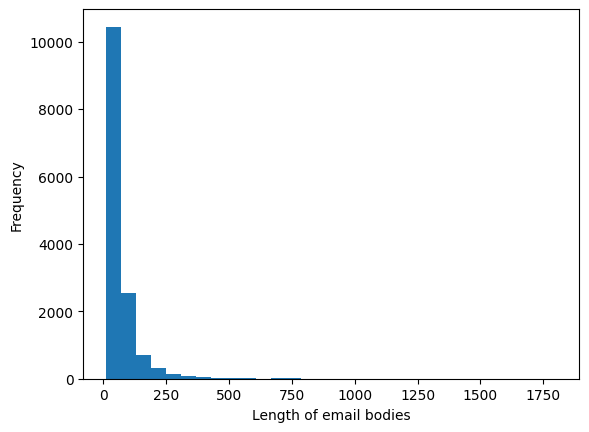

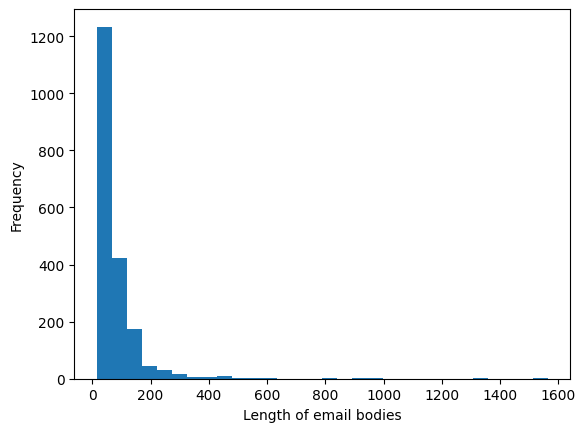

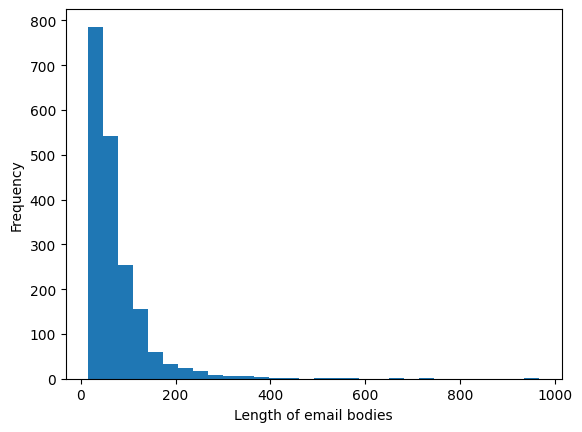

In [12]:
import matplotlib.pyplot as plt

def plot_data(data):
    lengths = [len(text.split()) for text in data['email_body']]
    plt.hist(lengths, bins=30)
    plt.xlabel('Length of email bodies')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_data)
plot_data(dev_data)
plot_data(test_data)


In [13]:
class EmailSubjectDataset(Dataset):
    def __init__(self, emails, subjects, tokenizer, max_length):
        self.emails = emails
        self.subjects = subjects
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        email_text = self.emails[idx]
        subject_text = self.subjects[idx]

        # Tokenize inputs and outputs
        inputs = self.tokenizer.encode_plus(email_text, max_length=self.max_length, padding='max_length', return_tensors='pt', truncation=True)
        outputs = self.tokenizer.encode_plus(subject_text, max_length=self.max_length, padding='max_length', return_tensors='pt', truncation=True)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': outputs['input_ids'].flatten()
        }

In [15]:
from transformers import Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import Dataset


In [16]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
dataset = EmailSubjectDataset(train_emails, tain_subjects, tokenizer, max_length=512)

In [18]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="epoch",
)

# Initialize model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Fine-tuning the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.035100,0.028897
2,0.030800,0.026359
3,0.029100,0.025784


TrainOutput(global_step=8661, training_loss=0.07325135850834799, metrics={'train_runtime': 3540.1154, 'train_samples_per_second': 9.786, 'train_steps_per_second': 2.447, 'total_flos': 4688781370195968.0, 'train_loss': 0.07325135850834799, 'epoch': 3.0})

In [20]:
# Function to generate subject lines from email text
def get_first_four_words_split(text):
    words = text.split()
    return ' '.join(words[:4])

In [21]:
def generate_subject(model, tokenizer, email_text, max_length=512):
    # Move model to correct device
    device = next(model.parameters()).device

    email_text = preprocess_text(email_text)

    input_ids = tokenizer.encode(email_text, return_tensors='pt').to(device)  # Move input_ids to device

    # Generate subject line
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)

    generated_subject = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_subject

In [22]:
# Example usage of subject line generation
example_email = "The following reports have been waiting for your approval for more than 4 days.Please review.Owner: James W Reitmeyer Report Name: JReitmeyer 10/24/01 Days In Mgr.Queue: 5"
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))

Generated Subject: Jreitmeyer Day 5


In [23]:
example_email = "All,  The below Analyst & Associate recruiting dates require ENA participation at Manager level at above.In order to resource each of your departments it is important to have ENA's involvement and participation in the interviews and debrief sessions on Fantastic Friday and Super Saturday events.These de-brief sessions will allow you the opportunity to select candidates you wish to join your groups.The target  is to assign potential candidates to business units and departments from the outset.As ENA has the highest percentage of A&A rotating in its business unit, the participation of ENA at interview should reflect this.Therefore, please encourage your direct reports and managers to participate in the below events in order to secure candidates for your business area.Associate Recruiting:		Saturday November 3						Total - 70 Candidates for Interview Analyst Recruiting:		Friday, November 16						Total - 70 Candidates for Interivew Associate Recruiting:		Saturday, December 1						Total - 70 Candidates for Interview  The above spreadsheet represents ENA's particpation today which I believe highlights the need for much additional support in these efforts.Please confirm by return participation of your respective groups.Regards,"
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))

Generated Subject: Ena Particpation


In [24]:
example_email = "Late on October 25th, we received information about a nonspecific threat to the Enron Center.We communicated with law enforcement officials who found the threat unsubstantiated and without merit.Nonetheless we take all threats seriously and have increased the security presence at the Enron Center still further.Once again, if you observe suspicious behavior, please call security at 3-6200."
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))


Generated Subject: Enron


In [25]:
example_email = "Thanks in advance for agreeing to speak at the Global Operations Controller  Forum.There will be approximately 30 Enron business controllers present at  the meeting.All have responsibility for mid and back office operations for  the following Enron entities:  Enron North America, Enron Europe, Enron South  America, Enron Global Markets, Enron Industrial Markets, Enron Broadband  Services and Enron Energy Services.Attendees will be here from Houston,  Calgary, Tokyo, Sydney, London and New York (metals business).Attached for your reference is the agenda.There may be some slight changes  before the forum begins, but this will give you a good idea of the topics to  be covered and the other speakers who will address the group.You are scheduled to address the group as follows:"
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))

Generated Subject: Speaker Address Scheduled Address


In [26]:
example_email = "To confirm:  Mark Thomas Mike Presley  both previously on the list for Netco's Market Risk/Research Group have resigned.I'm combing the Estate for replacements.DP"
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))

Generated Subject: Netco Market Group Combing


In [27]:
example_email = "Michelle;  This is the presentation which was provided to the HR VP's.The HR VPs were tasked with going off to met their BU OTCs and devise plans around the three components.We are currently collating those plans into one document.We'll send that along to you when completed.Pls call if you have any questions."
generated_subject = generate_subject(model, tokenizer, example_email)
print("Generated Subject:", get_first_four_words_split(generated_subject))

Generated Subject: Hr Hr vps tasked


In [28]:
# Evaluate the model
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.025784295052289963, 'eval_runtime': 86.7759, 'eval_samples_per_second': 33.281, 'eval_steps_per_second': 8.32, 'epoch': 3.0}


In [29]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=98de4fce41f16580a25547b65a0bb32fad590b3ab188294cce898cbd2ad60a2e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [30]:
from rouge_score import rouge_scorer, scoring

In [31]:
import re

# Sample email body
email_body = """
All: Attached you will find a list that reflects your seat assignments for Business Continuity Planning (BCP).
These seats are located on the 30th and 31st Floors of Enron Center North (ECN).
As previously communicated, you will report to these designated seats in the event of an outage in ECS.
The exception to this is as follows: If your seat assignment is located on the 31st Floor, you will report to your original location that you occupied prior to your move into ECS.
This will hold true until the Monday after Thanksgiving, as we will have the 31st floor seats set up at that time.
Testing: Once you have moved to ECS, if you would like to test your BCP location, you will be able to test your seat for functionality every Thursday from 3-6pm.
Testing is not required, but is highly recommended.
If anyone has any questions or concerns about these procedures, please feel free to contact me at any time.
Regards,

@subject
BCP Seat Assignments

@ann0
your seat assignments for business continuity planning (bcp).

@ann1
bcp seat assignments

@ann2
here are your seat assignments for the business continuity planning event
"""

In [32]:
# Define a function to extract annotations
def extract_annotations(email_body):
    annotations = {}
    final_annotations = []
    current_annotation = None

    # Split the email body by lines
    lines = email_body.strip().split('\n')

    # Iterate through each line
    for line in lines:
        line = line.strip()

        # Check if line starts with @ann
        if line.startswith('@ann'):
            current_annotation = line
            annotations[current_annotation] = []
        elif current_annotation:
            # Append line to current annotation's text
            annotations[current_annotation].append(line)

    # Join lines of each annotation and return as dictionary values
    for key in annotations:
        annotations[key] = ' '.join(annotations[key])

    for key, value in annotations.items():
        final_annotations.append(value)

    return final_annotations

In [33]:
import os
from rouge import Rouge


In [34]:
def calculate_rouge_scores(hypotheses, references):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

In [35]:
data_dir = '/content/AESLC/enron_subject_line/test'

In [36]:
def extract_text_subject(email_body):
    # Check if @ann0 is present
    pattern_with_ann0 = r'@subject\n(.+?)\n@ann0'
    pattern_without_ann0 = r'@subject\n(.+)'
    if re.search('@ann0', email_body):
        match = re.search(pattern_with_ann0, email_body, re.DOTALL)
        if match:
            return match.group(1).strip()
    else:
        match = re.search(pattern_without_ann0, email_body, re.DOTALL)
        if match:
            return match.group(1).strip()

    return None  # Return None if no match found

In [37]:
# Function to load data from a directory
def load_data_from_directory(data_dir):
    hypotheses = []
    references = []

    # Iterate over files in the directory
    count =1
    for filename in os.listdir(data_dir):
        count = count+1
        if count > 600:
            break
        print(filename)
        with open(os.path.join(data_dir, filename), 'r', encoding='utf-8', errors='ignore') as file:
            email_text = file.read()

            annotations =  extract_annotations(email_text)
            # Extract subject from email body using regex

            subject = extract_text_subject(email_text)
            annotations.append(subject)

            pattern = r'(.+)(?=@subject)'

            # Use re.search to find the matching text
            match = re.search(pattern, email_text, re.DOTALL)
            text_before_subject = ""
            if match:
                text_before_subject = match.group(1).strip()
                # print("Text before @subject:")
                # print(text_before_subject)
            else:
                print("No match found.")
            text_before_subject = text_before_subject[:512]
            hypotheses.append(get_first_four_words_split(generate_subject(model,tokenizer,text_before_subject)))
            references.append(annotations)
            #print(annotations)




    return hypotheses, references

In [38]:
# Generate hypotheses and references
hypotheses, references = load_data_from_directory(data_dir)
hypotheses = [hypothesis.strip() for hypothesis in hypotheses]
references = [' '.join(reference).strip() for reference in references]

nemec-g_inbox_868.subject
sanders-r_inbox_9.subject
stclair-c_sent_32.subject
martin-t_inbox_141.subject
nemec-g_sent_2310.subject
lay-k_inbox_126.subject
may-l_inbox_280.subject
lay-k_inbox_227.subject
beck-s_sent_243.subject
holst-k_inbox_18.subject
campbell-l_inbox_419.subject
jones-t_sent_2407.subject
richey-c_inbox_18.subject
rodrique-r_sent_576.subject
baughman-d_inbox_120.subject
mcconnell-m_sent_424.subject
keavey-p_inbox_212.subject
cash-m_inbox_51.subject
lay-k_inbox_719.subject
symes-k_sent_403.subject
lay-k_inbox_340.subject
dasovich-j_sent_567.subject
lay-k_inbox_102.subject
jones-t_sent_5941.subject
tycholiz-b_inbox_280.subject
farmer-d_inbox_54.subject
shackleton-s_sent_391.subject
dorland-c_inbox_4.subject
townsend-j_inbox_280.subject
saibi-e_inbox_591.subject
haedicke-m_sent_48.subject
platter-p_inbox_330.subject
germany-c_sent_1145.subject
sturm-f_sent_72.subject
sturm-f_inbox_104.subject
mann-k_sent_1681.subject
jones-t_sent_669.subject
nemec-g_sent_2571.subject
hols

In [39]:
hypotheses

['GISB Gas',
 'Friday plea',
 'Derek could call sometime',
 'Email Send E-Mail',
 'GUARANTEE',
 'EDT Bear Stearns -',
 "I'm a new company",
 'Trade Press Medium inquiry',
 "I'm looking forward to",
 'Alot of time in',
 'ICAP Working Group',
 'Tana Jones, Senior Legal',
 'New Common Estate Removed',
 'Book Included Portfolio Thanks',
 'Enron Center North 1400',
 'EMG going to rmcdonald',
 'EIM 20 Years Experience',
 'Hr vps vps vps',
 "I'm not going to",
 'fyi believe entered deal',
 'New News: Last week',
 'COMMUNITY OF PERFORMANCE',
 'Senator Bingaman Reid',
 'Counterparty Trade - go',
 'Xcel Presentations',
 "I'm a member of",
 'Please advise sara',
 'Compani',
 'Enron Center South',
 'Excel Document Outage',
 'Weather Data Region 98',
 'U Market Uncertainty',
 'Navarro Contract 1 Day',
 'EOL',
 'NRC request inspection late',
 'The main bed breakfast',
 'GTC counterparty sells U',
 'Call Gerald',
 'Enron Parking & Transportation',
 'Attached memo for attempt',
 'TRY & VXmails',
 'Nex

In [41]:
from rouge import Rouge

def calculate_rouge_scores(hypotheses, references):
    if not hypotheses:
        raise ValueError("Hypotheses list is empty.")
    if not references:
        raise ValueError("References list is empty.")

    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

# Example hypotheses and references (ensure these are populated with actual data)
hypotheses = ["The cat sat on the mat.", "There is a cat on the mat."]
references = ["The cat is on the mat.", "A cat is sitting on the mat."]

print("Hypotheses:", hypotheses)
print("References:", references)

try:
    rouge_scores = calculate_rouge_scores(hypotheses, references)

    # Print ROUGE scores
    print("ROUGE Scores:")
    print("ROUGE-1 (Recall):", rouge_scores['rouge-1'])
    print("ROUGE-2 (Recall):", rouge_scores['rouge-2'])
    print("ROUGE-L (Recall):", rouge_scores['rouge-l'])
except ValueError as e:
    print(e)


Hypotheses: ['The cat sat on the mat.', 'There is a cat on the mat.']
References: ['The cat is on the mat.', 'A cat is sitting on the mat.']
ROUGE Scores:
ROUGE-1 (Recall): {'r': 0.7738095238095238, 'p': 0.7738095238095238, 'f': 0.773809518809524}
ROUGE-2 (Recall): {'r': 0.4666666666666667, 'p': 0.4666666666666667, 'f': 0.46666666166666676}
ROUGE-L (Recall): {'r': 0.7023809523809523, 'p': 0.7023809523809523, 'f': 0.7023809473809526}
